- `|t_p - t_c|`や`(t_p - t_c)^2`は、steepness of the growth also monotonically increases away from the minimum, both of them are said to be *convex*. 絶対値はsteepness変わらないけど。
- Cases where the loss is a **convex function** of the model parameters are usually great to deal with because we can **find a minimum very efficiently** through specialized algorithms.

In [1]:
from PIL import Image
import torch

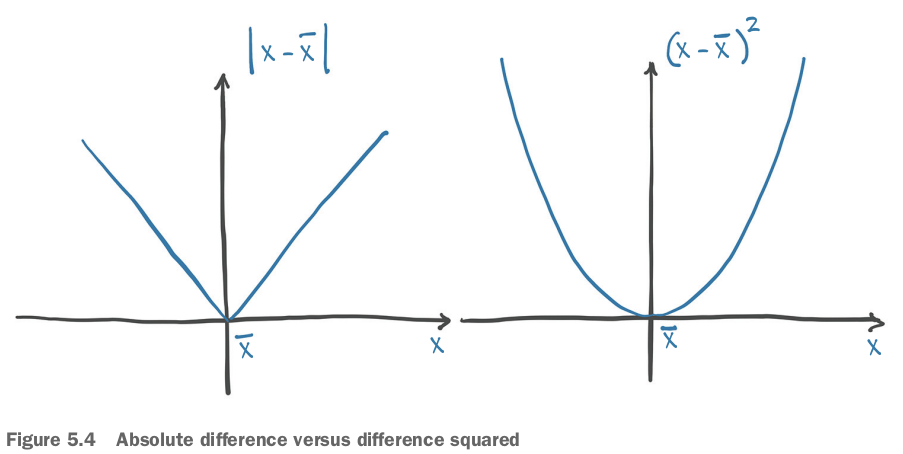

In [2]:
Image.open('img/two-loss-2020-12-19-19-47-52.png')

- Square difference penalizes **wildly wrong results** more than the absolute difference does. 

### 5.3.1 From problem back to PyTorch

In [3]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

- Write our the model as a Python function:

In [4]:
def model(t_u, w, b):
    return w * t_u + b

In [5]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

- **It is a *mean square loss***.
- initialize the parameters, invoke the model:

In [6]:
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [7]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

### Broadcasting
- rules:
    - **For each index dimension, counted from the back, if one of the operands is size 1 in that dimension, PyTorch will use the single entry along this dimension with each of the entries in the other tensor along this dimension**.
    - If both sizes are greater than 1, they must be the same, and natural matching is used.
    - If **one of the tensors has more index dimensions than the other**, **the entirety of the other tensor will be used for each entry along these dimensions**.

In [8]:
x = torch.ones(())
y = torch.ones(3, 1)
z = torch.ones(1, 3)
a = torch.ones(2, 1, 1)

In [9]:
(y + z).shape

torch.Size([3, 3])

In [10]:
(y + z + a).shape

torch.Size([2, 3, 3])

## 5.4 Down along the gradient
- Gradient descent is actually a very simple idea, and it **scales up surprisingly** well to large neural network models with millions of parameters.

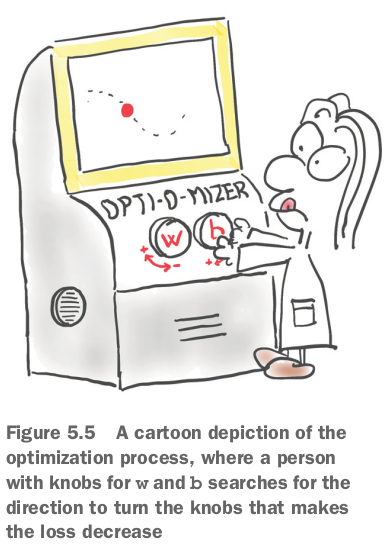

In [11]:
Image.open('img/knobs-2020-12-19-20-26-52.png')

### 5.4.1 Decreasing loss
- Add a small number to `w` and `b` and see how much the loss changes in that neighborhood:

In [13]:
delta = 0.1

loss_rate_of_change_w = (loss_fn(model(t_u, w + delta, b), t_c) - 
                        loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)
loss_rate_of_change_w

tensor(4517.2974)

- If the change is negative, then we need to increase `w` to minimize the loss, whereas if the change is positive, we need to decrease `w`.
- By how much?
    - Applying a change to `w` that is **proportional to the rate of change of the loss** is a good idea, **especially when the loss has several parameters**: we apply a change to those that exert a significant change on the loss.
    - It is also wise to change the parameters slowly in general.

In [14]:
learning_rate = 1e-2

w = w - learning_rate * loss_rate_of_change_w
w

tensor(-44.1730)

In [16]:
loss_rate_of_change_b = (loss_fn(model(t_u, w, b + delta), t_c) - 
                        loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)

b = b - learning_rate * loss_rate_of_change_b
loss_rate_of_change_b, b

(tensor(-4510.), tensor(91.1000))

### 5.4.2 Getting analytical
- loss functionがmodel outputに対する微分：

In [17]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0) # the division is from the derivative of mean.
    return dsq_diffs

- model ouputがw, bに対する微分：

In [18]:
def dmodel_dw(t_u, w, b):
    return t_u

In [19]:
def dmodel_db(t_u, w, b):
    return 1.0

- putting together, gradient functionは：

In [22]:
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    # the summation is the reverse of the broadcasting we implicitly do 
    # when applying the parameters to an entire vector of inputs in the model. よく分かっていない。。。
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

### 5.4.3 Iterating to fit the model
- the training loop:

In [24]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c, print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params
        
        t_p = model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)
        
        params = params - learning_rate * grad
        
        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')
        if not torch.isfinite(loss).all(): # lossにinf, -infが出たら、break
            break
        
    return params

In [25]:
training_loop(n_epochs=100,
             learning_rate=1e-2,
             params=torch.tensor([1.0, 0.0]),
             t_u=t_u,
             t_c=t_c)

Epoch 1, Loss 1763.884766
    Params: tensor([-44.1730,  -0.8260])
    Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 5802484.500000
    Params: tensor([2568.4011,   45.1637])
    Grad:   tensor([-261257.4062,   -4598.9702])
Epoch 3, Loss 19408029696.000000
    Params: tensor([-148527.7344,   -2616.3931])
    Grad:   tensor([15109614.0000,   266155.6875])
...
Epoch 10, Loss 90901105189019073810297959556841472.000000
    Params: tensor([3.2144e+17, 5.6621e+15])
    Grad:   tensor([-3.2700e+19, -5.7600e+17])
Epoch 11, Loss inf
    Params: tensor([-1.8590e+19, -3.2746e+17])
    Grad:   tensor([1.8912e+21, 3.3313e+19])


tensor([-1.8590e+19, -3.2746e+17])

- 可笑しい:our training process literally (simply or just) blew up, leading to losses becoming `inf`.
- This is a clear sign that `params` is **receiving updates that are too large**, and their values start **oscillating back and forth as each update overshoots and the next overcorrects even more**.
- The optimization process is unstable: it *diverges* instead of converging to a minimum.
- We want to see **smaller and smaller updates to `params`**, not larger.

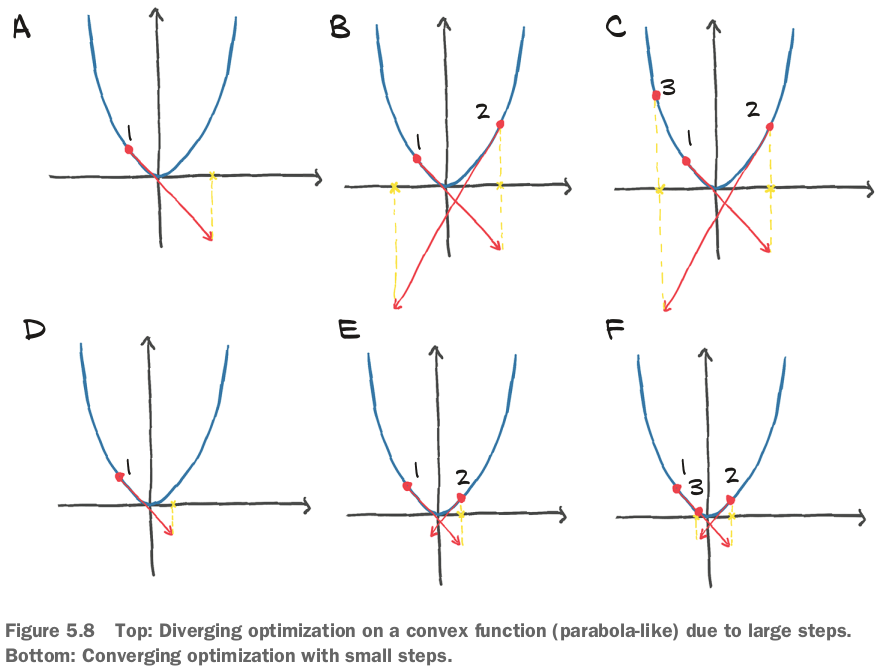

In [26]:
Image.open('img/diverge-vs-converge-2020-12-20-10-41-54.png')

- We usually change learning rates by orders of magnitude, so we might try with `1e-3` or `1e-4`, which would decrease the magnitude of the updates by orders of magnitude:

In [27]:
training_loop(n_epochs=100,
             learning_rate=1e-4,
             params=torch.tensor([1.0, 0.0]),
             t_u=t_u,
             t_c=t_c)

Epoch 1, Loss 1763.884766
    Params: tensor([ 0.5483, -0.0083])
    Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 323.090515
    Params: tensor([ 0.3623, -0.0118])
    Grad:   tensor([1859.5493,   35.7843])
Epoch 3, Loss 78.929634
    Params: tensor([ 0.2858, -0.0135])
    Grad:   tensor([765.4666,  16.5122])
...
Epoch 10, Loss 29.105247
    Params: tensor([ 0.2324, -0.0166])
    Grad:   tensor([1.4803, 3.0544])
Epoch 11, Loss 29.104168
    Params: tensor([ 0.2323, -0.0169])
    Grad:   tensor([0.5781, 3.0384])
...
Epoch 99, Loss 29.023582
    Params: tensor([ 0.2327, -0.0435])
    Grad:   tensor([-0.0533,  3.0226])
Epoch 100, Loss 29.022667
    Params: tensor([ 0.2327, -0.0438])
    Grad:   tensor([-0.0532,  3.0226])


tensor([ 0.2327, -0.0438])

- Another problem: the updates to parameters are very small, so the loss decreases very slowly and eventually stalls.
- We could obviate this issue by **making `learning_rate` adaptive**: change according to the magnitude of updates.
- There's another potential troublemaker: the gradient itself.

### 5.4.4 Normalizing inputs
- The first-epoch gradient for the weight is about 50 times larger than the gradient for the bias. (**live in differently scaled spaces**)
- If this is the case, a learning rate that's large enough to meaningfully update one will be so large as to be unstable for the other; and a rate that's appropriate for the other won't be large enough to meaningfully change the first.
- ここはただ`t_u`掛け0.1:

In [28]:
t_un = 0.1 * t_u

In [29]:
training_loop(n_epochs=100,
             learning_rate=1e-2,
             params=torch.tensor([1.0, 0.0]),
             t_u=t_un,
             t_c=t_c)

Epoch 1, Loss 80.364342
    Params: tensor([1.7761, 0.1064])
    Grad:   tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.574913
    Params: tensor([2.0848, 0.1303])
    Grad:   tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
    Params: tensor([2.2094, 0.1217])
    Grad:   tensor([-12.4631,   0.8587])
...
Epoch 10, Loss 29.030489
    Params: tensor([ 2.3232, -0.0710])
    Grad:   tensor([-0.5355,  2.9295])
Epoch 11, Loss 28.941877
    Params: tensor([ 2.3284, -0.1003])
    Grad:   tensor([-0.5240,  2.9264])
...
Epoch 99, Loss 22.214186
    Params: tensor([ 2.7508, -2.4910])
    Grad:   tensor([-0.4453,  2.5208])
Epoch 100, Loss 22.148710
    Params: tensor([ 2.7553, -2.5162])
    Grad:   tensor([-0.4446,  2.5165])


tensor([ 2.7553, -2.5162])

- We could probably do a better job of normalization than a simple rescaling by a factor.
- run the loop for enough iterations:

In [31]:
params = training_loop(n_epochs=5000,
             learning_rate=1e-2,
             params=torch.tensor([1.0, 0.0]),
             t_u=t_un,
             t_c=t_c,
             print_params=False)
params

Epoch 1, Loss 80.364342
Epoch 2, Loss 37.574913
Epoch 3, Loss 30.871077
...
Epoch 10, Loss 29.030489
Epoch 11, Loss 28.941877
...
Epoch 99, Loss 22.214186
Epoch 100, Loss 22.148710
...
Epoch 4000, Loss 2.927680
Epoch 5000, Loss 2.927648


tensor([  5.3671, -17.3012])

### 5.4.5 Visualizing (again)

In [32]:
%matplotlib inline
from matplotlib import pyplot as plt

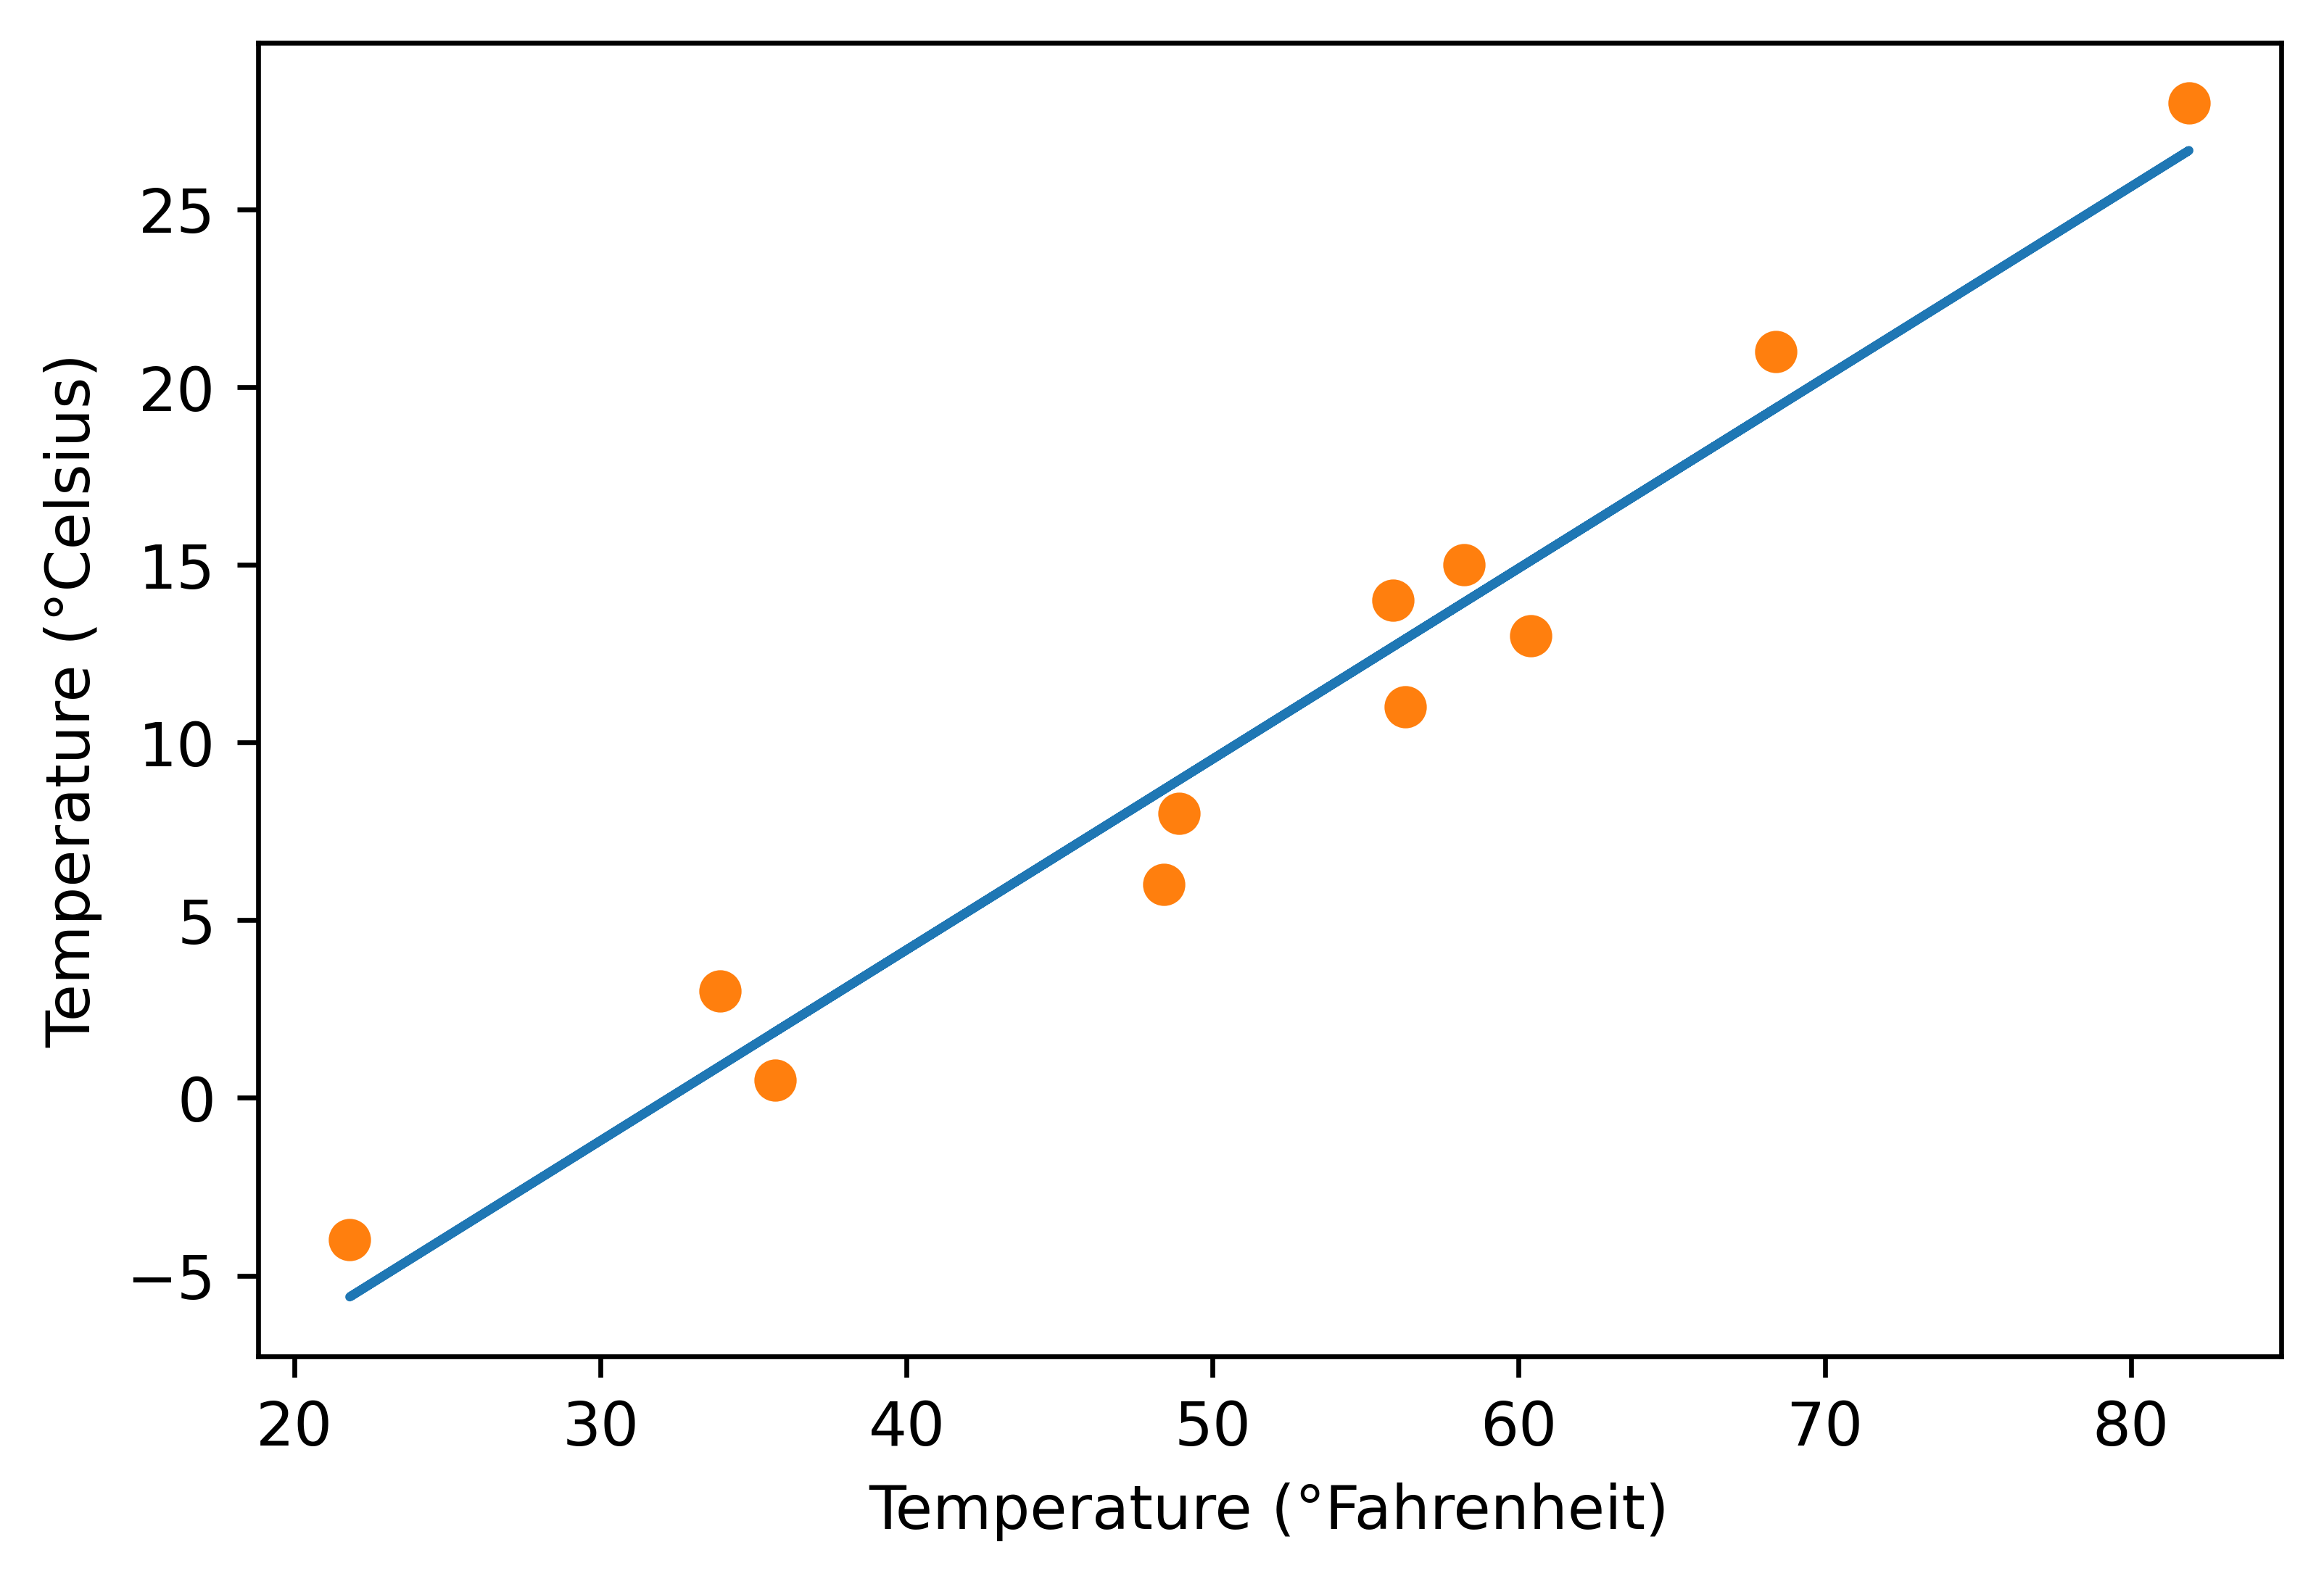

In [33]:
t_p = model(t_un, *params) # argument unpacking

fig = plt.figure(dpi=600)
plt.xlabel('Temperature (°Fahrenheit)')
plt.ylabel('Temperature (°Celsius)')
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

- We are using a Python trick called *argument unpacking* here: `*params` means to pass the elements of `params` as individual arguments.
    - In Python, this is **usually done with lists or tuples**, but we can also **use argument unpacking with PyTorch tensors**, which are split along the leading dimension.
    - So here, `model(t_un, *params)` is equivalent to `mode(t_un, params[0], params[1])`.